In [493]:
import pandas as pd
import pymc3 as pm
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from vega_datasets.data import 
import altair as alt
from altair import datum

from tqdm import tqdm_notebook as tqdm

pd.set_option('chained_assignment',None)

In [326]:
sns.set_style('darkgrid')

## Load Maddison data

In [15]:
maddison_raw = pd.read_excel("../../data/mpd2018.xlsx", sheet_name=1)
maddison_raw.head()

,countrycode,country,year,cgdppc,rgdpnapc,pop,i_cig,i_bm
0,AFG,Afghanistan,1820,NaN,NaN,3280.0,NaN,NaN
1,AFG,Afghanistan,1870,NaN,NaN,4207.0,NaN,NaN
2,AFG,Afghanistan,1913,NaN,NaN,5730.0,NaN,NaN
3,AFG,Afghanistan,1950,2392.0,2392.0,8150.0,Extrapolated,NaN
4,AFG,Afghanistan,1951,2422.0,2422.0,8284.0,Extrapolated,NaN


In [29]:
maddison = maddison_raw.drop(['i_cig', 'i_bm', 'rgdpnapc'], axis=1)
maddison = maddison[maddison.year >= 1950]

column_map = {old:new for old, new in zip(('countrycode','country','cgdppc','pop'),
                                          ('ccode','country','mad','mad_pop'))}
maddison.columns = [column_map[x] if x in column_map.keys() else x for x in maddison.columns ]

former_cntries = ['PRI', 'SUN', 'CSK', 'YUG']
maddison = maddison.loc[~maddison.ccode.isin(former_cntries)]
maddison.loc[:,"mad_pop"] = maddison.mad_pop / 1000

In [30]:
maddison.head()

,ccode,country,year,mad,mad_pop
3,AFG,Afghanistan,1950,2392.0,8.150
4,AFG,Afghanistan,1951,2422.0,8.284
5,AFG,Afghanistan,1952,2462.0,8.425
6,AFG,Afghanistan,1953,2568.0,8.573
7,AFG,Afghanistan,1954,2576.0,8.728


## Load WDI data

In [159]:
wdi_raw = pd.read_csv("../../data/wdi.csv")
year_cols = [x[:4] for x in wdi_raw.columns if "YR" in x]
wdi_raw.columns = list(wdi_raw.columns[:4]) + year_cols

In [157]:
wdi = wdi_raw[~wdi_raw['Country Code'].isnull()]
wdi[year_cols] = wdi[year_cols].apply(lambda x: pd.to_numeric(x, errors='coerce'))
wdi.loc[wdi['Series Name'] == "Population, total", 'Series Name'] = "pop"
wdi.loc[wdi['Series Name'].str.contains("PPP"), 'Series Name'] = "gdpppp"
wdi.loc[wdi['Series Name'].str.contains("2010"), 'Series Name'] = "gdpconst"
wdi.loc[wdi['Series Name'].str.contains("LCU"), 'Series Name'] = "gdpconstlcu"
wdi.drop('Series Code', axis=1, inplace=True)
wdi.columns = ['country', 'ccode'] + list(wdi.columns[2:])
wdi = wdi.set_index(['country','ccode', 'Series Name']).stack().reset_index()
wdi.columns = ['country', 'ccode', 'Series Name', 'year', 'value']
wdi = wdi.pivot_table(index=['country','ccode', 'year'],  
                      values='value', columns='Series Name').reset_index()

wdi = wdi.loc[~(wdi.gdpppp.isna() & wdi.gdpconst.isna())]
wdi = wdi.sort_values(['ccode', 'year'])
wdi.head()

Series Name,country,ccode,year,gdpconst,gdpconstlcu,gdpppp,pop
630,Aruba,ABW,2010,24271.940421,NaN,NaN,101669.0
631,Aruba,ABW,2011,NaN,NaN,35973.780510,102053.0
42,Afghanistan,AFG,2002,364.570573,8438.166963,1063.635574,21979923.0
43,Afghanistan,AFG,2003,376.758714,8720.267545,1099.194507,23064851.0
44,Afghanistan,AFG,2004,364.095436,8427.169682,1062.249360,24118979.0


In [193]:
all_df = []
for x, df in wdi.groupby('ccode'):
    df['gdpconstgrowth'] = df['gdpconst'] / df['gdpconst'].shift(1)
    
    gdppp_na = df.gdpppp.isna()
    gdpconst_na = df.gdpconst.isna()
    mask = gdppp_na & ~(gdppp_na.shift(-1).fillna(True)) & \
            ~gdpconst_na & ~(gdpconst_na.shift(-1).fillna(True))
    
    df.loc[mask, 'gdpppp'] = df.gdpppp.shift(-1)/df.gdpconstgrowth.shift(-1)
    
    all_df.append(df)
    #if missing(gdpppp) & !missing(gdpppp[_n - 1]) & !missing(gdpconst) & !missing(gdpconst[_n - 1])
wdi_2 = pd.concat(all_df)
wdi_2 = wdi_2.rename(columns=dict(zip(('gdpconst','gdpppp','pop'),('wdi_const','wdi','wdi_pop'))), )
wdi_2.loc[:, 'wdi_pop'] = wdi_2.wdi_pop / 1000000
wdi_2 = wdi_2.drop(['gdpconstgrowth','wdi_const'], axis=1)
wdi_2['year'] = wdi_2.year.astype('int')
wdi_2.head()

Series Name,country,ccode,year,gdpconstlcu,wdi,wdi_pop
630,Aruba,ABW,2010,NaN,NaN,0.101669
631,Aruba,ABW,2011,NaN,35973.780510,0.102053
42,Afghanistan,AFG,2002,8438.166963,1063.635574,21.979923
43,Afghanistan,AFG,2003,8720.267545,1099.194507,23.064851
44,Afghanistan,AFG,2004,8427.169682,1062.249360,24.118979


## Load PWT data

In [181]:
pwt = pd.read_excel("../../data/pwt90.xlsx", sheet_name="Data")
pwt = pwt[['countrycode','country','year','pop','rgdpe']]
pwt = pwt.rename(columns={'countrycode':'ccode', 'pop':'pwt_pop', 'rgdpe':'pwt'})
pwt['pwt'] = pwt['pwt'] / pwt['pwt_pop']
pwt = pwt[~pwt.pwt_pop.isna()]

In [182]:
pwt.head()

,ccode,country,year,pwt_pop,pwt
20,ABW,Aruba,1970,0.059065,5910.776697
21,ABW,Aruba,1971,0.059438,6403.035401
22,ABW,Aruba,1972,0.059849,6936.818520
23,ABW,Aruba,1973,0.060239,7517.112905
24,ABW,Aruba,1974,0.060525,8136.407851


## Merge all the datasets

In [539]:
oil_countries = ["DZA", "AGO" , "AZE", "BHR", "BRN", "TCD", "COG", "ECU", "GNQ",
                 "GAB", "IRN", "IRQ", "KAZ", "KWT", "NGA", "OMN", "QAT", "RUS",
                 "SAU", "TTO", "TKM", "ARE", "VEN", "YEM", "LBY", "TLS", "SDN"]

all_df = pwt.merge(maddison, on=['ccode', 'year'], how='outer',
          suffixes=('','_m')).merge(wdi_2, on=['ccode', 'year'], how='outer', suffixes=('','_w'))

all_df['oil'] = all_df.ccode.isin(oil_countries)
all_df['no_oil'] = ~all_df['oil']

# Small countries
for data in ['mad', 'pwt', 'wdi']:
    all_df['big_'+ data] = (all_df[data+'_pop'] >= 1)

# Restrict sample
for var in ['mad', 'pwt', 'wdi']:
    all_df.loc[~all_df[f"big_{var}"], var] = np.nan
    
all_df = all_df[all_df.no_oil]

### Load WB classification

In [540]:
groups = pd.read_excel("../../data/OGHIST.xls", 
              sheet_name="Country Analytical History", 
              usecols = "A:B,D", names=['ccode', 'country','group1990'], 
              skiprows=10)

In [543]:
combined_data = all_df.merge(groups, on='ccode', suffixes=('', "_grp"), how='left')
combined_data = combined_data[['ccode', 'pwt_pop', 'mad_pop', 'country', 'year', 'pwt', 'mad', 'wdi', 'group1990']]

# Descriptives

Need to create the dataset for regressions

In [544]:
firstyear = 1960
lastyear = 2016

In [545]:
all_dfs = []

for cntry, df in tqdm(combined_data.groupby('ccode')):    
    for data in ['mad', 'wdi', 'pwt']:
        not_null =  df.loc[~df[data].isnull()]
        if len(not_null) > 0:
            firstyear = not_null["year"].min()
            lastyear = not_null["year"].max()
            for startyear in range(firstyear, lastyear):
                den = lastyear - startyear
                startyear_val = df.loc[df.year == startyear, data].values[0]
                lastyear_val = df.loc[df.year == lastyear, data].values[0]
                df.loc[df.year == startyear, data + '_outcome'] = np.log(lastyear_val/startyear_val) / den
                df.loc[df.year == startyear, data + '_initial'] = np.log(startyear_val)
    all_dfs.append(df.sort_values('year'))

all_df = pd.concat(all_dfs)
    

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



In [548]:
all_df.to_csv("../../output/all_df.csv", index=False)

In [676]:
all_df.head()

,ccode,country,group1990,mad,mad_initial,mad_outcome,mad_pop,pwt,pwt_initial,pwt_outcome,pwt_pop,wdi,wdi_initial,wdi_outcome,year
0,ABW,Aruba,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.059065,NaN,NaN,NaN,1970
1,ABW,Aruba,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.059438,NaN,NaN,NaN,1971
2,ABW,Aruba,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.059849,NaN,NaN,NaN,1972
3,ABW,Aruba,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.060239,NaN,NaN,NaN,1973
4,ABW,Aruba,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.060525,NaN,NaN,NaN,1974


,country,mad_initial,mad_outcome,pwt_initial,pwt_outcome,mad_pop,pwt_pop,group1990,year
125,Albania,8.779404,0.050166,8.717573,0.061899,3.030,3.082172,..,2005
190,Argentina,9.604542,0.021043,9.562407,0.039123,39.368,39.145491,UM,2005
215,Armenia,8.551015,0.056114,8.519928,0.059773,2.951,3.014917,..,2005
325,Australia,10.625174,0.007674,10.594480,0.008457,20.059,20.274282,H,2005
390,Austria,10.536168,0.016225,10.540840,0.025864,8.276,8.234858,H,2005


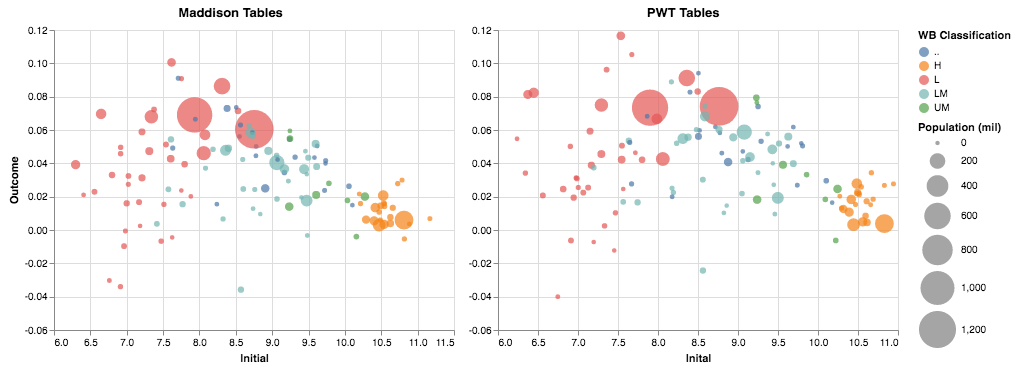

In [776]:
sub_df = all_df[all_df.year == 2005]
sub_df = sub_df.loc[~sub_df.pwt_initial.isna(), ['country', 'mad_initial', 'mad_outcome', 'pwt_initial','pwt_outcome','mad_pop','pwt_pop', 'group1990', 'year']]
sub_df.head()

alt.data_transformers.enable('default', max_rows=20000)
brush = alt.selection(type='interval', resolve='global')

base = alt.Chart(sub_df).mark_circle().add_selection(
    brush
).properties(
    width=400,
    height=300,
)

mad_alt = base.encode(
    x=alt.X('mad_initial', scale=alt.Scale(zero=False), title='Initial'),
    y=alt.Y('mad_outcome', title='Outcome'),
    color=alt.condition(brush, 'group1990', alt.ColorValue('gray'), title="WB Classification"),
    size=alt.Size('mad_pop', scale=alt.Scale(range=[20, 1500])),
    tooltip = [alt.Tooltip('country', title='Country'), 
               alt.Tooltip('mad_initial', title='Intial GDPCC', format="0.2f"),
               alt.Tooltip('mad_outcome', title='Change in GDPCC', format="0.2f")
              ]
).properties(
    title="Maddison Tables"
)

pwt_alt = base.encode(
    x=alt.X('pwt_initial', scale=alt.Scale(zero=False), title='Inital'),
    y=alt.Y('pwt_outcome', title=''),
    color=alt.condition(brush, 'group1990', alt.ColorValue('gray'), title="WB Classification"),
    size=alt.Size('pwt_pop', title='Population (mil)', scale=alt.Scale(range=[20, 1500])),
    tooltip = [alt.Tooltip('country', title='Country'), 
               alt.Tooltip('pwt_initial', title='Intial GDPCC', format="0.2f"),
               alt.Tooltip('pwt_outcome', title='Change in GDPCC', format="0.2f")
              ]
).properties(
    title="PWT Tables"
)


alt.hconcat(mad_alt , pwt_alt).resolve_scale(y='shared')

,country,mad_initial,mad_outcome,pwt_initial,pwt_outcome,mad_pop,pwt_pop,group1990,year
90,Albania,7.991931,0.029115,8.115413,0.026347,2.157,2.150602,..,1970
155,Argentina,9.414016,0.009174,8.289735,0.036927,23.962,23.973062,UM,1970
290,Australia,9.902987,0.017535,9.860705,0.018407,12.660,12.904760,H,1970
355,Austria,9.512147,0.026141,9.531626,0.028227,7.467,7.509746,H,1970
410,Burundi,6.972606,-0.009413,6.606904,0.000971,3.522,3.457113,L,1970


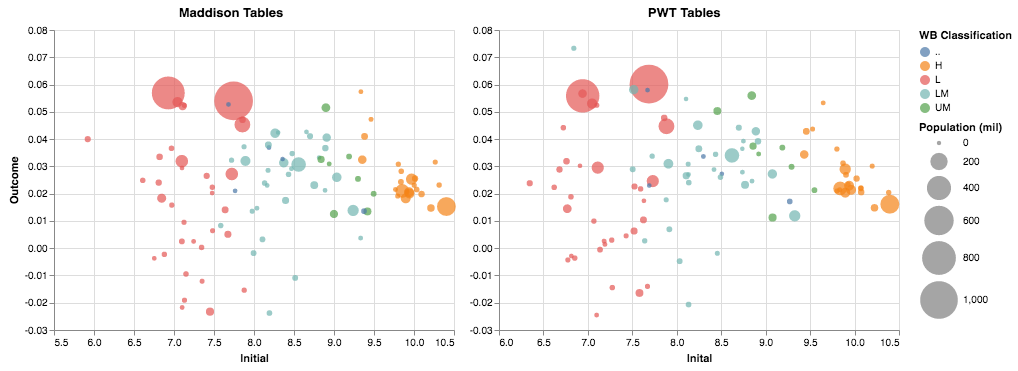

In [775]:
sub_df = all_df[all_df.year == 1985]
sub_df = sub_df.loc[~sub_df.pwt_initial.isna(), ['country', 'mad_initial', 'mad_outcome', 'pwt_initial','pwt_outcome','mad_pop','pwt_pop', 'group1990', 'year']]

alt.data_transformers.enable('default', max_rows=20000)

brush = alt.selection(type='interval', resolve='global')
base = alt.Chart(sub_df).mark_circle().add_selection(
    brush
).properties(
    width=400,
    height=300,
)

mad_alt = base.encode(
    x=alt.X('mad_initial', scale=alt.Scale(zero=False), title='Initial'),
    y=alt.Y('mad_outcome', title='Outcome'),
    color=alt.condition(brush, 'group1990', alt.ColorValue('gray'), title="WB Classification"),
    size=alt.Size('mad_pop', scale=alt.Scale(range=[20, 1500])),
    tooltip = [alt.Tooltip('country', title='Country'), 
               alt.Tooltip('mad_initial', title='Intial GDPCC', format="0.2f"),
               alt.Tooltip('mad_outcome', title='Change in GDPCC', format="0.2f")
              ]
).properties(
    title="Maddison Tables"
)

pwt_alt = base.encode(
    x=alt.X('pwt_initial', scale=alt.Scale(zero=False), title='Inital'),
    y=alt.Y('pwt_outcome', title=''),
    color=alt.condition(brush, 'group1990', alt.ColorValue('gray'), title="WB Classification"),
    size=alt.Size('pwt_pop', title='Population (mil)', scale=alt.Scale(range=[20, 1500])),
    tooltip = [alt.Tooltip('country', title='Country'), 
               alt.Tooltip('pwt_initial', title='Intial GDPCC', format="0.2f"),
               alt.Tooltip('pwt_outcome', title='Change in GDPCC', format="0.2f")
              ]
).properties(
    title="PWT Tables"
)


alt.hconcat(mad_alt , pwt_alt).resolve_scale(y='shared')


# Gaussian Random walk 


## For maddison tables

In [448]:
reg_df = all_df[~all_df.mad_outcome.isna() & ~all_df.mad_initial.isna()]

nyears = reg_df.year.nunique()
year_idx = reg_df.year.values - 1950

outcome = reg_df.mad_outcome.values
inital = reg_df.mad_initial.values

unique_years = np.sort(reg_df.year.unique())

In [458]:
with pm.Model() as model_mad:
    
    sig_alpha = pm.Exponential('sig_alpha', 50)
    sig_beta = pm.Exponential('sig_beta', 50)
    
    alpha = pm.GaussianRandomWalk('alpha', sd =sig_alpha, shape=nyears)
    beta = pm.GaussianRandomWalk('beta', sd =sig_beta, shape=nyears)
    
    pred_growth = alpha[year_idx] + beta[year_idx] * inital
    sd = pm.HalfNormal('sd', sd=1.0, shape = nyears)
    
    likelihood = pm.Normal('outcome',
                           mu=pred_growth,
                           sd=sd[year_idx],
                           observed=outcome)
       

In [459]:
trace_mad = pm.sample(tune=1000, model=model_mad, samples = 300)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, beta, alpha, sig_beta, sig_alpha]
Sampling 4 chains: 100%|██████████| 6000/6000 [01:11<00:00, 55.97draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


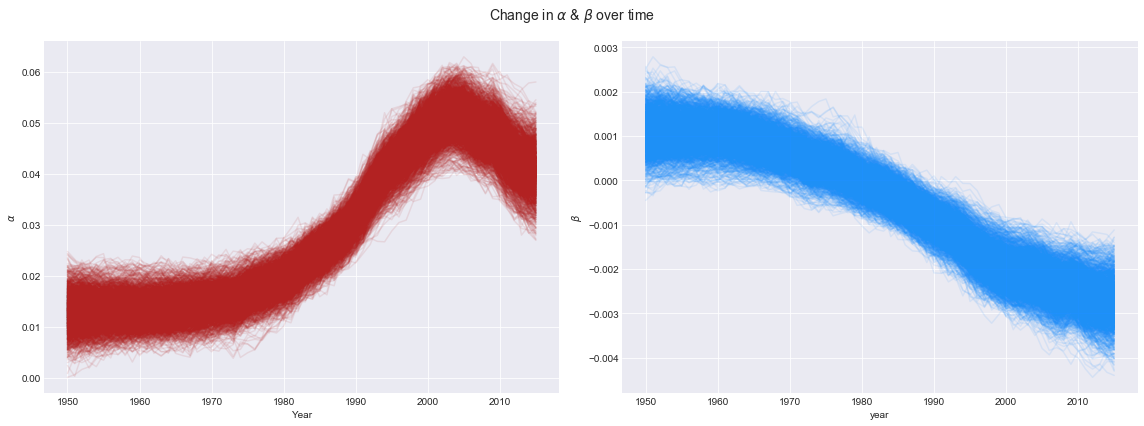

In [777]:
labels = [unique_years[i] for i in range(0, nyears, 10)]

f, (ax1, ax2) = plt.subplots(1,2,figsize=(16, 6))

#ax1.set_xlabel='year', ylabel='alpha', title='Change of alpha over time.')
ax1.plot(trace_mad['alpha'].T, 'firebrick', alpha=.1);
ax1.set_xticklabels([1950] + labels);
ax1.set_xlabel("Year")
ax1.set_ylabel(r"$\alpha$")

ax2.plot(trace_mad['beta'].T, 'dodgerblue', alpha=.1);
ax2.set_xticklabels([1950] + labels);
ax2.set_xlabel("year")
ax2.set_ylabel(r"$\beta$")
plt.suptitle(r"Change in $\alpha$ & $\beta$ over time", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.savefig("../../output/coefficient_drift.png")

In [782]:
pm.summary(trace_mad, varnames=['sig_beta'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sig_beta,0.000162,0.000031,0.000002,0.000107,0.000225,123.689081,1.004744


## For Penn World tables

In [437]:
reg_df = all_df[~all_df.pwt_outcome.isna() & ~all_df.pwt_initial.isna()]

nyears = reg_df.year.nunique()
year_idx = reg_df.year.values - 1950

outcome = reg_df.pwt_outcome.values
initial = reg_df.pwt_initial.values

unique_years = np.sort(reg_df.year.unique())

In [434]:
with pm.Model() as model_pwt:
    
    sig_alpha = pm.Exponential('sig_alpha', 50)
    sig_beta = pm.Exponential('sig_beta', 50)
    
    alpha = pm.GaussianRandomWalk('alpha', sd =sig_alpha, shape=nyears)
    beta = pm.GaussianRandomWalk('beta', sd =sig_beta, shape=nyears)
    
    pred_growth = alpha[year_idx] + beta[year_idx] * initial
    sd = pm.HalfNormal('sd', sd=1.0, shape=nyears)
    
    likelihood = pm.Normal('outcome',
                           mu=pred_growth,
                           sd=sd[year_idx],
                           observed=outcome)
       

In [435]:
trace_pwt = pm.sample(tune=1000, model=model_pwt, samples = 300)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, beta, alpha, sig_beta, sig_alpha]
Sampling 4 chains: 100%|██████████| 6000/6000 [01:16<00:00, 78.87draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


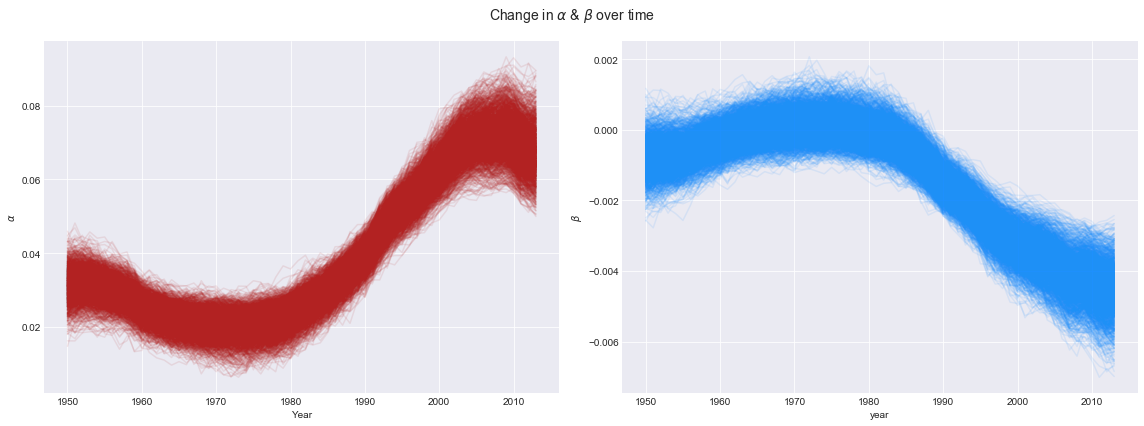

In [461]:
labels = [unique_years[i] for i in range(0, nyears, 10)]

f, (ax1, ax2) = plt.subplots(1,2,figsize=(16, 6))

#ax1.set_xlabel='year', ylabel='alpha', title='Change of alpha over time.')
ax1.plot(trace_pwt['alpha'].T, 'firebrick', alpha=.1);
ax1.set_xticklabels([1950] + labels);
ax1.set_xlabel("Year")
ax1.set_ylabel(r"$\alpha$")

ax2.plot(trace_pwt['beta'].T, 'dodgerblue', alpha=.1);
ax2.set_xticklabels([1950] + labels);
ax2.set_xlabel("year")
ax2.set_ylabel(r"$\beta$")
plt.suptitle(r"Change in $\alpha$ & $\beta$ over time", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.savefig("../../output/coefficient_drift_pwt.png")

In [783]:
pm.summary(trace_pwt, varnames=['sig_beta'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sig_beta,0.000227,0.000044,0.000003,0.000148,0.000316,130.264389,1.011597


## For WDI

In [422]:
reg_df = all_df[~all_df.wdi_outcome.isna() & ~all_df.wdi_initial.isna()]

nyears = reg_df.year.nunique()
year_idx = np.sort(reg_df.year.values) - reg_df.year.values.min()

outcome = reg_df.wdi_outcome.values
initial = reg_df.wdi_initial.values

unique_years = np.sort(reg_df.year.unique())

In [424]:
with pm.Model() as model_wdi:
    
    sig_alpha = pm.Exponential('sig_alpha', 50)
    sig_beta = pm.Exponential('sig_beta', 50)
    
    alpha = pm.GaussianRandomWalk('alpha', sd =sig_alpha, shape=nyears)
    beta = pm.GaussianRandomWalk('beta', sd =sig_beta, shape=nyears)
    
    pred_growth = alpha[year_idx] + beta[year_idx] * initial
    sd = pm.HalfNormal('sd', sd=1.0)
    
    likelihood = pm.Normal('outcome',
                           mu=pred_growth,
                           sd=sd,
                           observed=outcome)
       

In [425]:
trace_wdi = pm.sample(tune=1000, model=model_wdi, samples = 300)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, beta, alpha, sig_beta, sig_alpha]
Sampling 4 chains: 100%|██████████| 6000/6000 [01:08<00:00, 87.74draws/s]


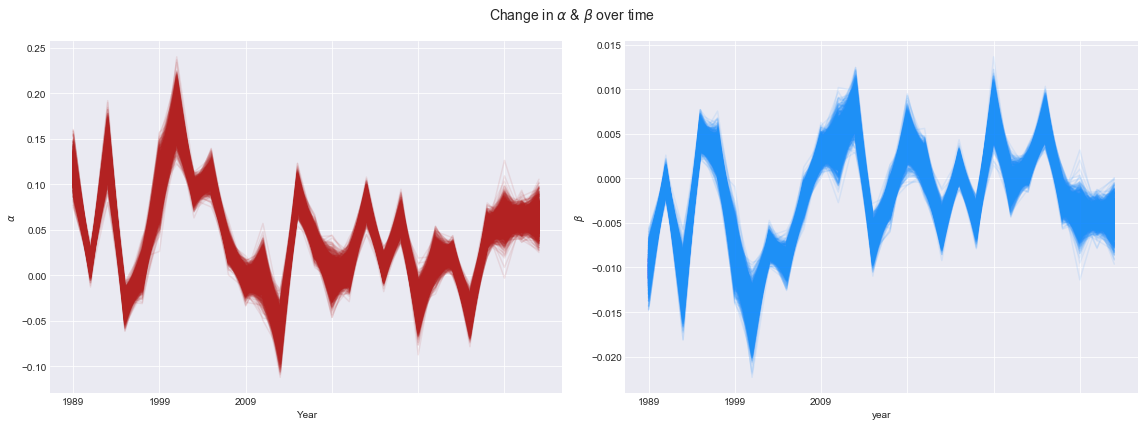

In [427]:
labels = [unique_years[i] for i in range(0, nyears, 10)]

f, (ax1, ax2) = plt.subplots(1,2,figsize=(16, 6))

#ax1.set_xlabel='year', ylabel='alpha', title='Change of alpha over time.')
ax1.plot(trace_wdi['alpha'].T, 'firebrick', alpha=.1);
ax1.set_xticklabels([1950] + labels);
ax1.set_xlabel("Year")
ax1.set_ylabel(r"$\alpha$")

ax2.plot(trace_wdi['beta'].T, 'dodgerblue', alpha=.1);
ax2.set_xticklabels([1950] + labels);
ax2.set_xlabel("year")
ax2.set_ylabel(r"$\beta$")
plt.suptitle(r"Change in $\alpha$ & $\beta$ over time", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.savefig("../../output/coefficient_drift_wdi.png")

## Combining plots for PWT and MT

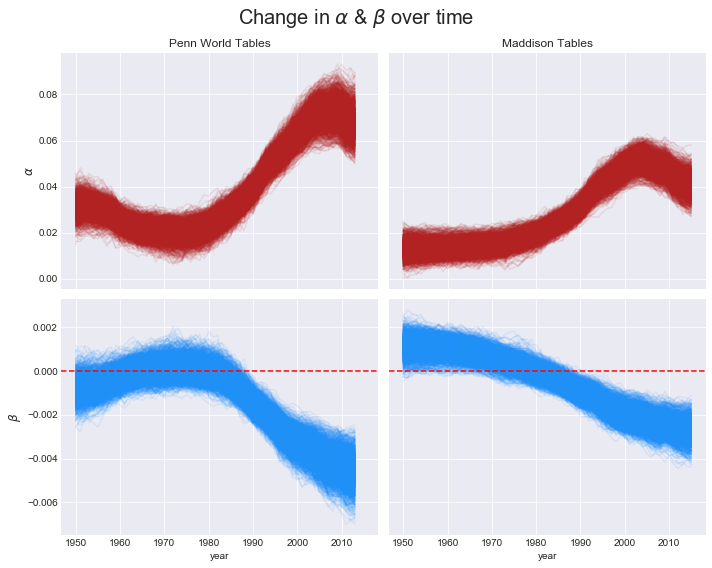

In [480]:
labels = [unique_years[i] for i in range(0, nyears, 10)]

f, axes = plt.subplots(2,2,figsize=(10, 8), sharex=True, sharey='row')

ax1, ax2, ax3, ax4 = axes.ravel()

ax1.plot(trace_pwt['alpha'].T, 'firebrick', alpha=.1);
ax1.set_xticklabels([1950] + labels);
ax1.set_ylabel(r"$\alpha$", fontsize=12)
ax1.set_title("Penn World Tables")

ax3.plot(trace_pwt['beta'].T, 'dodgerblue', alpha=.1);
ax3.set_xticklabels([1950] + labels);
ax3.set_xlabel("year")
ax3.set_ylabel(r"$\beta$", fontsize=12)
ax3.axhline(y=0, ls='--', color='r')

ax2.plot(trace_mad['alpha'].T, 'firebrick', alpha=.1);
ax2.set_xticklabels([1950] + labels);
#ax2.set_ylabel(r"$\alpha$", fontsize=12)
ax2.set_title("Maddison Tables")

ax4.plot(trace_mad['beta'].T, 'dodgerblue', alpha=.1);
ax4.set_xticklabels([1950] + labels);
ax4.set_xlabel("year")
#ax4.set_ylabel(r"$\beta$", fontsize=12)
ax4.axhline(y=0, ls='--', color='r')

plt.suptitle(r"Change in $\alpha$ & $\beta$ over time", fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.90)

plt.savefig("../../../../../sidravi1.github.io/assets/2018_10_17_coefficient_drift_pwt_mad.png")